# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

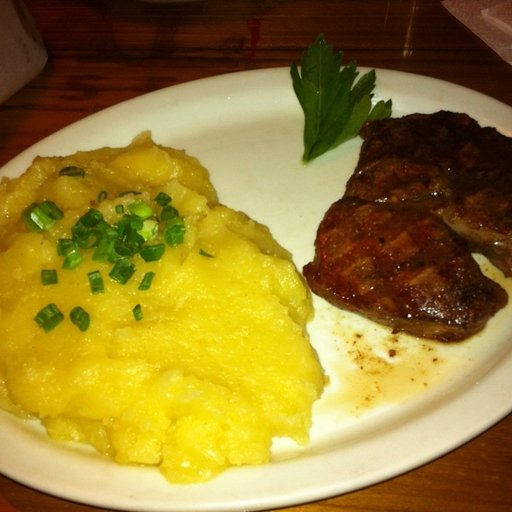

In [6]:
from PIL import Image
import random

# get sample
samples = random.sample(list(train_dir.glob("*/*.jpg")), 1)

# Visualize an image
img = Image.open(samples[0])
img

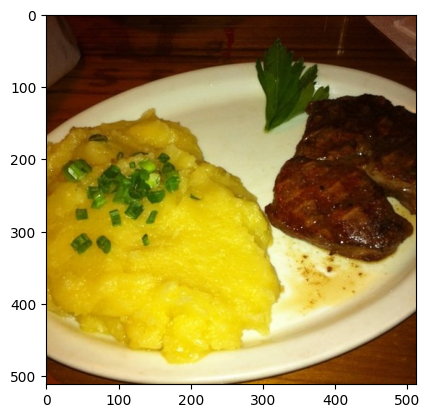

In [7]:
import matplotlib.pyplot as plt

# Do the image visualization with matplotlib
plt.imshow(img)
plt.show()

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [9]:
# Write transform for turning images into tensors
transformer_simple = transforms.Compose([transforms.Resize(size=(64,64)), transforms.ToTensor()])
transformer = transforms.Compose([transforms.Resize(size=(64,64)), transforms.TrivialAugmentWide(16), transforms.ToTensor()])

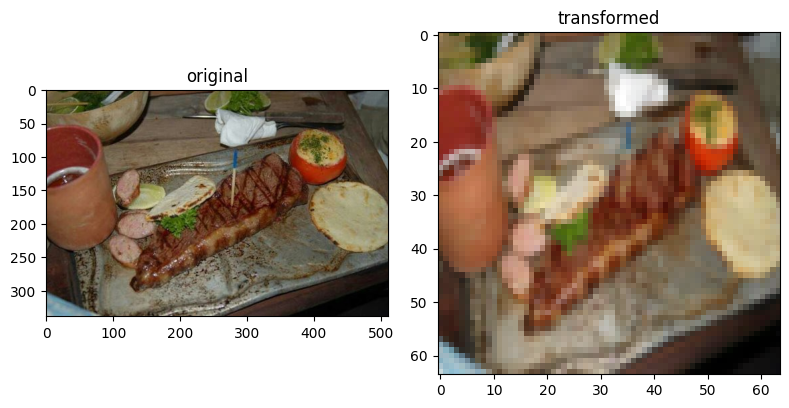

In [10]:
# Write a function to plot transformed images
def plot_transformed(img, transformer):
  fig, axs = plt.subplots(1,2,figsize=(8,4))
  axs[0].imshow(img)
  axs[0].set_title('original')
  img_t = transformer(img).permute(1, 2, 0)
  axs[1].imshow(img_t)
  axs[1].set_title('transformed')
  plt.tight_layout()
  plt.show()

# Visualize a sample
sample = random.sample(list(train_dir.glob("*/*.jpg")), 1)
img = Image.open(sample[0])
plot_transformed(img,transformer)

### Load image data using `ImageFolder`

In [11]:
from torchvision import datasets

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, transform=transformer)
test_data = datasets.ImageFolder(root=test_dir, transform=transformer_simple)

In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
from torch.utils.data import DataLoader

# Turn train and test Datasets into DataLoaders
train_data_loader = DataLoader(dataset=train_data, batch_size=1, num_workers=os.cpu_count())
test_data_loader = DataLoader(dataset=test_data, batch_size=1, num_workers=os.cpu_count())

train_data_loader, test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7a630710e6b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a630724eb60>)

In [16]:
# How many batches of images are in our data loaders?
len(iter(train_data_loader)), len(iter(test_data_loader)), next(iter(train_data_loader))[0].shape

(225, 75, torch.Size([1, 3, 64, 64]))

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [17]:
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary
import torch.nn as nn

In [18]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

# initiate the model
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
summary(model=model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [19]:
from sklearn.metrics import accuracy_score
import numpy as np

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss = []
  train_acc = []

  # Loop through data loader and data batches
  for X,y in dataloader:
    # Send data to target device
    X,y = X.to(device), y.to(device)
    # 1. Forward pass
    y_logit = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_logit, y)
    train_loss.append(loss.cpu().detach().numpy())
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    # Calculate and accumualte accuracy metric across all batches
    accuracy = accuracy_score(y.cpu(), torch.argmax(y_logit, dim=1).cpu())
    train_acc.append(accuracy)

  # Adjust metrics to get average loss and average accuracy per batch
  return np.mean(train_loss), np.mean(train_acc)

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  train_loss = []
  train_acc = []

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for X,y in dataloader:
      # Send data to target device
      X,y = X.to(device), y.to(device)
      # 1. Forward pass
      y_logit = model(X)
      # 2. Calculate and accumulate loss
      loss = loss_fn(y_logit, y)
      train_loss.append(loss.cpu().detach().numpy())
      # Calculate and accumulate accuracy
      accuracy = accuracy_score(y.cpu(), torch.argmax(y_logit, dim=1).cpu())
      train_acc.append(accuracy)

  # Adjust metrics to get average loss and accuracy per batch
  return np.mean(train_loss), np.mean(train_acc)

In [21]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [22]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
results_5_epoch = train(model=model,
      train_dataloader=train_data_loader,
      test_dataloader=test_data_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5820 | train_acc: 0.7378 | test_loss: 1.1001 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1214 | train_acc: 0.1956 | test_loss: 1.0949 | test_acc: 0.4133
Epoch: 3 | train_loss: 1.1117 | train_acc: 0.2000 | test_loss: 1.0955 | test_acc: 0.4133
Epoch: 4 | train_loss: 1.1108 | train_acc: 0.2044 | test_loss: 1.0960 | test_acc: 0.4133
Epoch: 5 | train_loss: 1.1103 | train_acc: 0.2044 | test_loss: 1.0964 | test_acc: 0.4133


In [23]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
results_20_epoch = train(model=model,
      train_dataloader=train_data_loader,
      test_dataloader=test_data_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1118 | train_acc: 0.2044 | test_loss: 1.0988 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.1088 | train_acc: 0.2489 | test_loss: 1.0990 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1087 | train_acc: 0.2533 | test_loss: 1.0990 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.1086 | train_acc: 0.2533 | test_loss: 1.0991 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.1086 | train_acc: 0.2578 | test_loss: 1.0991 | test_acc: 0.2533
Epoch: 6 | train_loss: 1.1086 | train_acc: 0.2578 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 7 | train_loss: 1.1086 | train_acc: 0.2578 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.1086 | train_acc: 0.2578 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.1086 | train_acc: 0.2622 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 10 | train_loss: 1.1086 | train_acc: 0.2622 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 11 | train_loss: 1.1086 | train_acc: 0.2622 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 12 | train_l

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [24]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model = TinyVGG(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)

results_20_epoch_double = train(model=model,
      train_dataloader=train_data_loader,
      test_dataloader=test_data_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0983 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 7 | train_loss: 1.0986 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.0983 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 10 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 11 | train_loss: 1.0986 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [25]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [26]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.


Excellent, we now have double the training and testing images...

In [27]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [28]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20 = datasets.ImageFolder(root=train_data_20_percent_path, transform=simple_transform)
test_data_20 = datasets.ImageFolder(root=test_data_20_percent_path, transform=simple_transform)
# Create dataloaders
train_data_loader_20 = DataLoader(dataset=train_data, batch_size=1, num_workers=os.cpu_count())
test_data_loader_20 = DataLoader(dataset=test_data, batch_size=1, num_workers=os.cpu_count())

train_data_loader_20, test_data_loader_20

(<torch.utils.data.dataloader.DataLoader at 0x7a63070e53c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a63070e7130>)

In [29]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model = TinyVGG(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)

results_20_epoch_double = train(model=model,
      train_dataloader=train_data_loader_20,
      test_dataloader=test_data_loader_20,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0983 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 7 | train_loss: 1.0986 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.0983 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 10 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 11 | train_loss: 1.0986 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 12 | train_l